In [1]:
import os,sys,string, time
import ROOT
from math import *
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
import Utilities.Variables_bins as Var_bins
import Utilities.Sys_unc_variables as sys_unc
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Loading in the "results" dataframe after full selection

In [2]:
Run = "run1" #so far either "run1" or "run3"

HNL_masses = Constants.HNL_mass_samples

loc_pkl = f'pkl_files/{Run}/current_files/Results/'

# overlay_results = pd.read_pickle(loc_pkl+"overlay_results.pkl") #This will contain all of the BDT output scores and rse_id

# loc_hists = 'bdt_output/'

# bins_dict = {}
# for HNL_mass in HNL_masses:
#     hist_placeholder = uproot.open(loc_hists+f'{Run}_{HNL_mass}MeV_logit_top_20_merged_FIXED.root')
#     bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges

## Loading in the preselected dataframe

In [3]:
loc_pkls_presel = "pkl_files/"+Run+"/current_files/my_vars/"
Presel_overlay = pd.read_pickle(loc_pkls_presel+"Preselected_overlay_"+Run+"_my_vars_flattened_ultimate.pkl")
print(Presel_overlay.keys())
# print(len(Presel_overlay))

Index(['run', 'sub', 'evt', 'nslice', 'n_pfps', 'n_tracks', 'n_showers',
       'swtrig_pre', 'swtrig_post', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_theta_v', 'shr_phi_v', 'shr_px_v', 'shr_py_v',
       'shr_pz_v', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2',
       'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_x_v',
       'trk_dir_y_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_hits_tot',
       'trk_energy_tot', 'trk_score_v', 'trk_calo_energy_u_v', 'trk_end_x_v',
       'trk_chipr_best', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'NeutrinoEnergy2', 'SliceCaloEnergy2', 'nu_flashmatch_score',
       'contained_sps_ratio', 'flash_time', 'contained_fraction', 'trk_score',
       'crtveto', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight',
       'min_x', 'max_x', 'min_y', 'max_y', 'min_z', 'max_z', 'highest_E'],
      dtype='object')


# Reading in the overlay .root file with reweight branches

In [4]:
sys_variables = Variables.sys_vars + Variables.event_vars + Variables.weight_related

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run1
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run3

df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


# Keeping only the events which pass selection in the weight dataframe

In [5]:
def make_unique_ev_id(df): #df must have 'run', 'sub' and 'evt' branches
    if pd.Series(['run', 'sub', 'evt']).isin(df.columns).all():
        rse_list = []
        for entry in df.index: #Looping over all events in the dataframe
            rse = str(df['run'][entry]) + "_" + str(df['sub'][entry]) + "_" + str(df['evt'][entry])
            rse_list.append(rse)
        df['rse_id'] = rse_list #Writing a new branch with the unique event id
        return df.copy()
    else:
        print("Dataframe needs \"run\", \"sub\" and \"evt\" columns.")
        return 0
    
def check_duplicate_events(df):
    rse_list = df['rse_id'].to_list()

    seen = set()
    dupes = []

    for x in rse_list:
        if x in seen:
            dupes.append(x)
        else:
            seen.add(x)
    print("Number of duplicates is " + str(len(dupes)))
    print("Number of unique events is " + str(len(seen)))

overlay_rse = make_unique_ev_id(Presel_overlay)
df_overlay_weights_rse = make_unique_ev_id(df_overlay_weights)

#Deleting any duplicates of events, should be able to avoid if correctly filtered for one event per row
overlay_rse.drop_duplicates(subset=['rse_id'], keep='first', inplace=True)

print("Number of events in weights file is " + str(len(df_overlay_weights_rse)))
print("Number of events in results file is " + str(len(overlay_rse)))

Number of events in weights file is 914729
Number of events in results file is 43764


In [6]:
#Keeping only those events in the final selection
filtered_weights = df_overlay_weights_rse.loc[(df_overlay_weights_rse['rse_id'].isin(overlay_rse['rse_id']))]

print("Number of events in the filtered weights file is " + str(len(filtered_weights)))
print("Number of events in results file is " + str(len(overlay_rse)))

Number of events in the filtered weights file is 43764
Number of events in results file is 43764


## Calculating uncertainty for a BDT input variable

In [7]:
print(filtered_weights.keys())
print(overlay_rse.keys())

Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id'],
      dtype='object')
Index(['run', 'sub', 'evt', 'nslice', 'n_pfps', 'n_tracks', 'n_showers',
       'swtrig_pre', 'swtrig_post', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_theta_v', 'shr_phi_v', 'shr_px_v', 'shr_py_v',
       'shr_pz_v', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2',
       'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_x_v',
       'trk_dir_y_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_hits_tot',
       'trk_energy_tot', 'trk_score_v', 'trk_calo_energy_u_v', 'trk_end_x_v',
       'trk_chipr_best', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'NeutrinoEnergy2', 'SliceCaloEnergy2', 'nu_flashmatch_score',
       'contained_sps_ratio', 'flash_time', 'contained_fraction', 'trk_score',
       'crtveto', 'weightSplineTime

In [12]:
have_sys = sys_unc.run1_Sys_unc.keys()
want_sys = ['min_x', 'max_x', 'min_y', 'max_y', 'min_z', 'max_z']
make_sys = []
for var in want_sys:
    if var not in have_sys:
        make_sys.append(var)
print(len(want_sys))
print(len(have_sys))
# print(have_sys)
print(len(make_sys))
print(make_sys)

6
30
6
['min_x', 'max_x', 'min_y', 'max_y', 'min_z', 'max_z']


In [13]:
reload(Var_bins)
bins_for = Var_bins.bins_var.keys()
make_bins = []
for var in make_sys:
    if var not in bins_for:
        make_bins.append(var)
print(make_bins)

[]


In [14]:
# HNL_masses = [20, 50, 100, 150, 180, 200] #Should get rid of this once made overlay branches with all results

Variable_list = make_sys

just_score_df = overlay_rse[Variable_list + ['rse_id','weight']].copy()

final_merged = pd.merge(filtered_weights,just_score_df, how='outer', on=['rse_id'])

In [15]:
final_merged.keys()

Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_z', 'max_z', 'weight'],
      dtype='object')

# Plotting the BDT score with all different multisims

In [16]:
def All_reweight_err(df, var_name, BINS, x_range, Norm, logit=False):
    results_dict = {}
    n_bins = len(BINS)-1
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0)
        n_cv_tot.fill(0)
        
        if logit == True:
            variable = Functions.logit(df[var_name]) #The BDT output score
        else:
            variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]*Norm
        spline_fix_var = df["weight"]*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=BINS, weights=spline_fix_cv)
        n_cv_tot += n_cv
        
        if(Multisim == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
                    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
                    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, 
                                           weights=np.nan_to_num(weight*spline_fix_var/df["weightSplineTimesTune"]), range=x_range, bins=BINS)
                    n_tot[i] += n
                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=BINS)
                    n_tot[i] += n
        
        if(Multisim == "weightsReint"):
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[np.isnan(weight)] = 1
                    weight[weight > 100] = 1
                    weight[weight < 0] = 1
                    weight[weight == np.inf] = 1
                    n, bins = np.histogram(variable, weights=weight*spline_fix_var, range=x_range, bins=BINS)
                    n_tot[i] += n
        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [17]:
reload(Var_bins)
bins_dict =  Var_bins.bins_var

In [18]:
# HNL_mass = 50
results_dict = {}
for Variable in Variable_list:
    print(f"Calculating {Variable} uncertainties.")
    results_dict[Variable] = All_reweight_err(final_merged, Variable, bins_dict[Variable],
                                    [bins_dict[Variable][0], bins_dict[Variable][-1]], Norm)

print("Done!")

Calculating min_x uncertainties.
Calculating max_x uncertainties.
Calculating min_y uncertainties.
Calculating max_y uncertainties.
Calculating min_z uncertainties.
Calculating max_z uncertainties.
Done!


In [19]:
def Plot_multisim(results_dict, Variable, savefig=False, display=True):
    for Multisim in results_dict:
        Nuniverse = Constants.Multisim_univs[Multisim]
        cov = results_dict[Multisim][0]
        cv = results_dict[Multisim][1]
        n_tot = results_dict[Multisim][2]
        bins = results_dict[Multisim][3]
        xlims = [min(bins), max(bins)]
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
        plt.sca(ax[0])

        # bins=np.linspace(0,1.0,21)

        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        nybins=70

        plt.title(Multisim + " Variations",fontsize=20)

        plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
        plt.legend()
        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        plt.ylabel("Events")
        plt.hist2d(bins_centlong,n_tot.flatten(),bins=[bins,nybins],cmin=1,range=[xlims,[0,max(cv)*1.4]],rasterized=True)

        plt.colorbar(pad=0,use_gridspec=True)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),pad=0,use_gridspec=True)
        plt.ylim(0,max(cv)*1.4)
        # plt.yscale("log")

        plt.sca(ax[1])
        
        #ax[1].tick_params(labelright=False, length=0)
        pos = ax[0].get_position()
        pos2 = ax[1].get_position()
        ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
        
        plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
        maxy = 1.5*max(plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')[0])
        plt.ylim(0,maxy)
        plt.ylabel("% Uncertainity")
        #plt.yticks([])
        plt.xlabel(f"{Variable}",fontsize=25)
        # plt.tight_layout()
        if savefig == True:
            plt.savefig("plots/Sys_uncertainty/Overlay/BDT_input_vars/bkg_multisim_" + Run + "_" + str(Variable) + "_MeV_" + Multisim + ".pdf")
            plt.savefig("plots/Sys_uncertainty/Overlay/BDT_input_vars/bkg_multisim_" + Run + "_" + str(Variable) + "_MeV_" + Multisim + ".png")
        if display == False:
            plt.close()

In [20]:
HNL_masses = Constants.HNL_mass_samples
for Variable in Variable_list:
    print(Variable)
    Plot_multisim(results_dict[Variable], Variable, savefig=False, display=False)
print("Done")

min_x


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


max_x
min_y
max_y
min_z
max_z


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Done


## Check fraction is flat across distribution

[2.80853    3.1459508  3.6290724  3.284913   3.2255561  3.3025618
 4.036079   3.588291   3.3060274  3.7703419  3.6291091  3.2809525
 3.578997   3.7043796  3.5129309  3.9093678  4.4186544  3.5810025
 3.7849991  3.5802546  4.04702    3.5279558  3.677966   3.788845
 3.6191316  3.9243565  4.065804   3.8178513  4.0654287  4.2444134
 3.7039573  4.298597   3.459438   4.228129   2.9337263  3.6086478
 2.544825   1.8976336  0.49543202 0.        ]
[0.62814564 1.3626633  2.546449   2.286342   2.281632   2.5235124
 2.7450778  2.4136074  3.7204657  2.770935   2.8581648  3.0889819
 3.5690877  3.3169641  3.2040741  3.3244023  3.8299043  3.3658822
 4.3962965  3.776962   4.065802   3.6038115  3.6090643  3.532287
 3.7098992  3.6172993  3.9604676  3.7191932  3.959751   4.8245397
 4.4007163  4.499013   3.698437   4.4623294  4.733292   4.3984513
 4.2156057  4.6002192  3.0415869  1.883242  ]
[3.0118585  3.9202683  3.8577924  3.7785509  4.2018337  4.222089
 3.529947   3.736107   4.2010508  3.5195117  4.089022

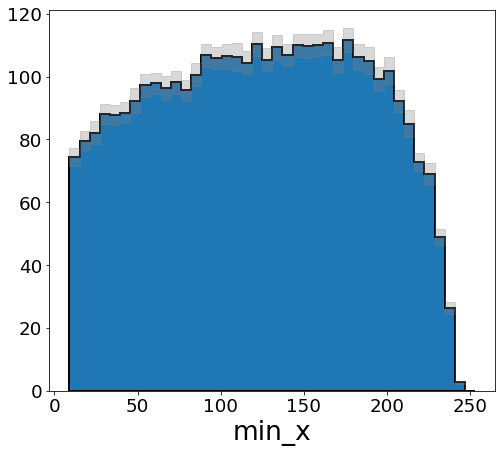

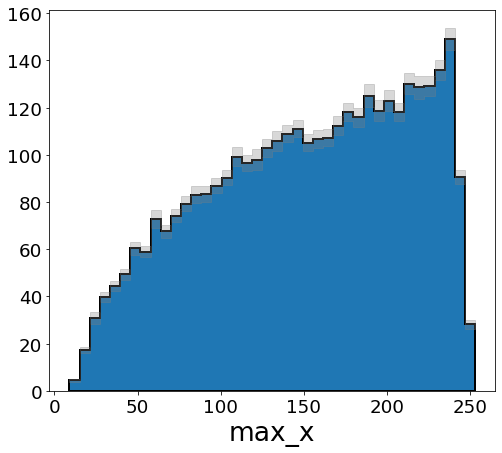

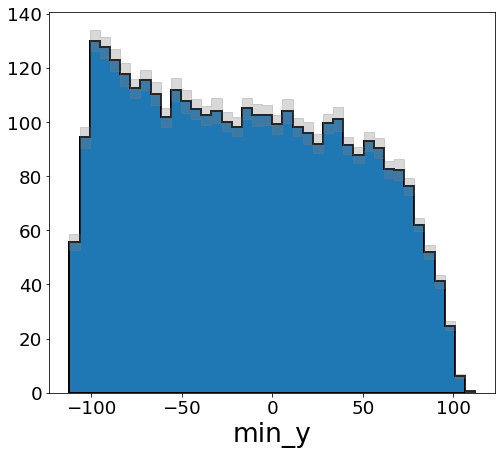

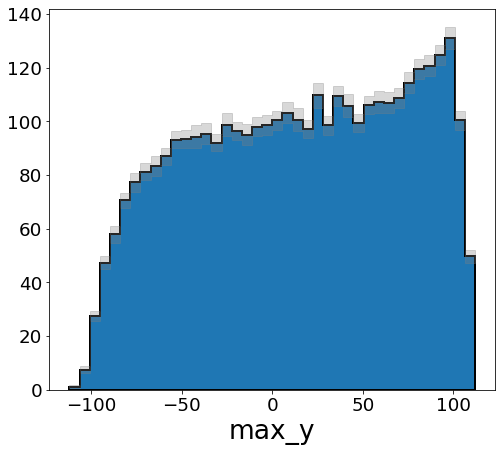

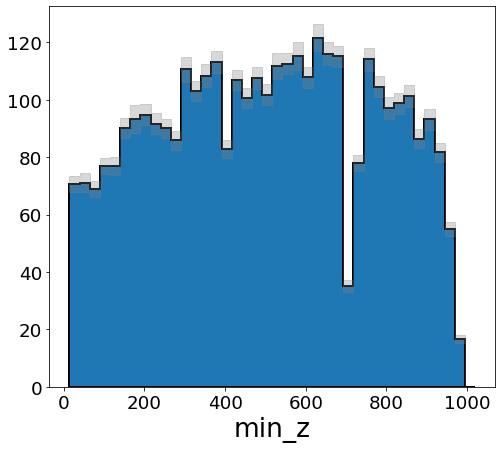

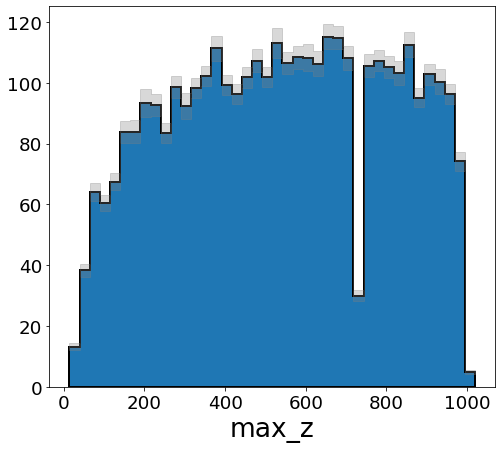

In [21]:
stat_bkgerr_dict = {}
tot_ppfx_err = {}
tot_genie_err = {}
tot_reint_err = {}
plot_dict = {}

for Variable in Variable_list:
    plt.figure(figsize=[8,7],facecolor='white')
    cov_ppfx = results_dict[Variable]["weightsPPFX"][0]
    cov_genie = results_dict[Variable]["weightsGenie"][0]
    cov_reint = results_dict[Variable]["weightsReint"][0]
    # var_Overlay = samples_dict["overlay"][Variable]

    varis=final_merged[Variable]
    weights=[final_merged["weight"]*Norm]
    labels=[fr"In-Cryo $\nu$"]
    xlims = [bins_dict[Variable][0],bins_dict[Variable][-1]]

    weight_Overlay=final_merged["weight"]*Norm
    #weighted hists
    overlaybkg_weighted=np.histogram(final_merged[Variable],bins=bins_dict[Variable],range=xlims,weights=weight_Overlay)[0]

    mc_w=np.histogram(final_merged[Variable],bins=bins_dict[Variable],range=xlims,weights=weight_Overlay**2)

    stat_bkgerr=np.sqrt(mc_w[0])
    stat_bkgerr_dict[Variable]=stat_bkgerr
    print(stat_bkgerr)

    tot_ppfx_err[Variable]=np.sqrt(np.diag(cov_ppfx))
    tot_genie_err[Variable]=np.sqrt(np.diag(cov_genie))
    tot_reint_err[Variable]=np.sqrt(np.diag(cov_reint))

    plot=plt.hist(varis, label=labels,range=xlims,bins=bins_dict[Variable],
                  histtype="stepfilled",stacked=True,density=False,linewidth=2,edgecolor="black",weights=weights)
    
    plot_dict[Variable]=plot
    
    upvals=np.append((plot[0]+stat_bkgerr),(plot[0]+stat_bkgerr)[-1])
    lowvals=np.append((plot[0]-stat_bkgerr),(plot[0]-stat_bkgerr)[-1])
    
    plt.fill_between(bins_dict[Variable], lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)
    plt.xlabel(Variable)

/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/i

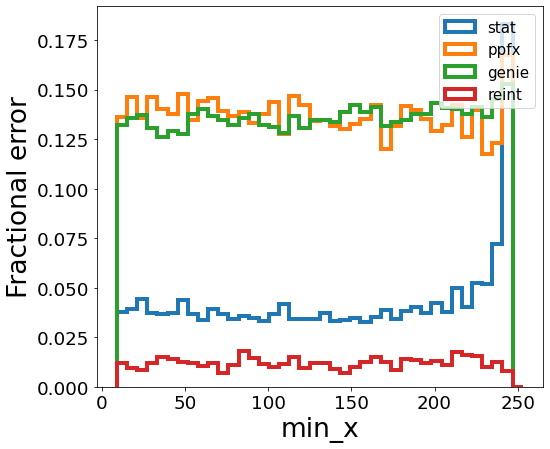

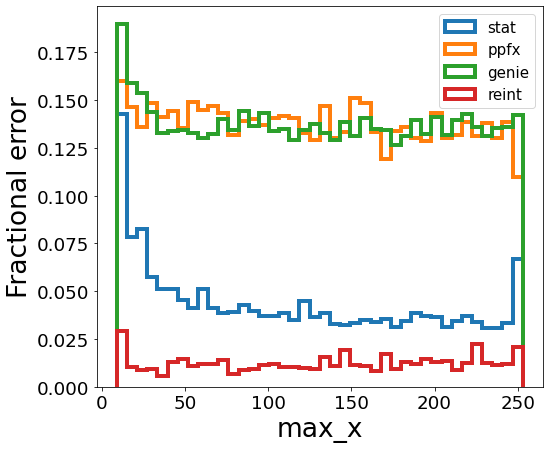

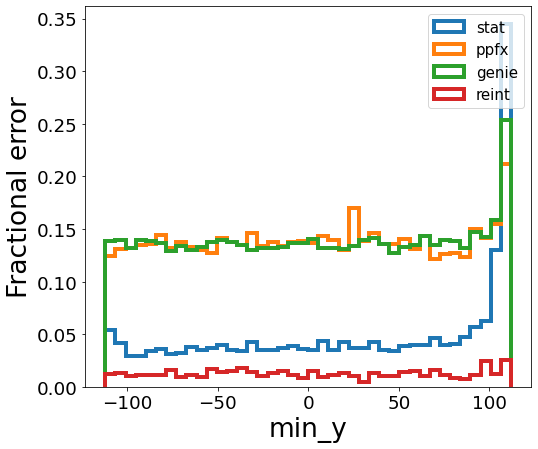

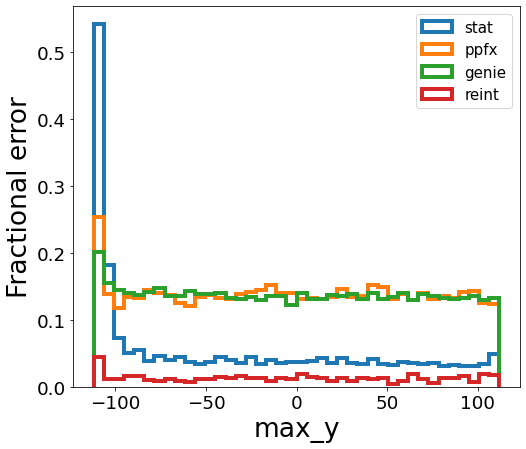

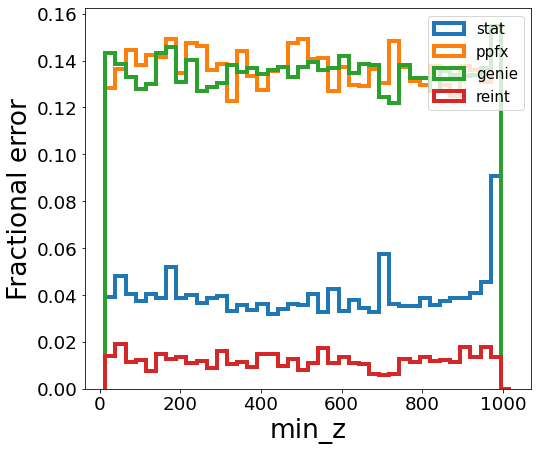

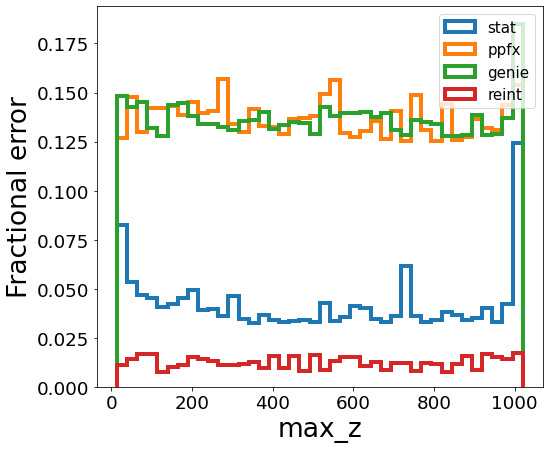

In [22]:
frac_dict, frac_ppfx_dict, frac_genie_dict, frac_reint_dict = {}, {}, {}, {}
for Variable in Variable_list:
    plt.figure(figsize=[8,7],facecolor='white')
    frac = np.divide(stat_bkgerr_dict[Variable], plot_dict[Variable][0])
    frac_ppfx = np.divide(tot_ppfx_err[Variable], plot_dict[Variable][0])
    frac_genie = np.divide(tot_genie_err[Variable], plot_dict[Variable][0])
    frac_reint = np.divide(tot_reint_err[Variable], plot_dict[Variable][0])
    
    frac_dict[Variable], frac_ppfx_dict[Variable], frac_genie_dict[Variable], frac_reint_dict[Variable] = frac, frac_ppfx, frac_genie, frac_reint

    bins_cent=(bins_dict[Variable][:-1]+bins_dict[Variable][1:])/2
    plt.hist(bins_cent,weights=np.nan_to_num(frac),bins=bins_dict[Variable],range=xlims,density=False, label="stat", histtype="step", lw=4)
    plt.hist(bins_cent,weights=np.nan_to_num(frac_ppfx),bins=bins_dict[Variable],range=xlims,density=False, label="ppfx", histtype="step", lw=4)
    plt.hist(bins_cent,weights=np.nan_to_num(frac_genie),bins=bins_dict[Variable],range=xlims,density=False, label="genie",  histtype="step", lw=4)
    plt.hist(bins_cent,weights=np.nan_to_num(frac_reint),bins=bins_dict[Variable],range=xlims,density=False, label="reint",  histtype="step", lw=4)
    
    plt.legend()

    plt.xlabel(Variable)
    plt.ylabel(f"Fractional error")
    plt.savefig("plots/Data_MC_comparison/Overlay_sys_unc/" + Run + f"_{Variable}_ppfx_and_genie_frac_err.png")

In [23]:
#Calculate average
print(Run)
for Variable in Variable_list:
    length = len(frac_ppfx_dict[Variable])
    total = sum(np.nan_to_num(frac_dict[Variable]))
    total_ppfx = sum(np.nan_to_num(frac_ppfx_dict[Variable]))
    total_genie = sum(np.nan_to_num(frac_genie_dict[Variable]))

    mean = total/length
    mean_ppfx = total_ppfx/length 
    mean_genie = total_genie/length 

    print(f"mean stat is {mean}")
    print(f"mean ppfx is {mean_ppfx}")
    print(f"mean genie is {mean_genie}")
    print()
    print(f"\"{Variable}\": [{round(mean_ppfx,3)},{round(mean_genie,3)}]")
    print("---------")

run1
mean stat is 0.041649078959170194
mean ppfx is 0.13363262118702246
mean genie is 0.13265854208623157

"min_x": [0.134,0.133]
---------
mean stat is 0.043718765199490695
mean ppfx is 0.13782657192657496
mean genie is 0.13793254588056436

"max_x": [0.138,0.138]
---------
mean stat is 0.04899767847701738
mean ppfx is 0.1388155402350769
mean genie is 0.13925997085361572

"min_y": [0.139,0.139]
---------
mean stat is 0.05534511842552786
mean ppfx is 0.13899517607188916
mean genie is 0.13796896623888472

"max_y": [0.139,0.138]
---------
mean stat is 0.03878683437071501
mean ppfx is 0.133695066313624
mean genie is 0.13193808838444643

"min_z": [0.134,0.132]
---------
mean stat is 0.042077680603913876
mean ppfx is 0.13709937152965593
mean genie is 0.13676348292692636

"max_z": [0.137,0.137]
---------


## Save uncertainty in Constants file
Use %load Utilities/Sys_unc_variables.py at the start of the file. 

Then %%writefile Utilities/Sys_unc_variables.py after editing

In [25]:
Utilities/Sys_unc_variables.py


Overwriting Utilities/Sys_unc_variables.py


## End of code